# Imports

In [125]:
import db_connection as db
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import DataFrame
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from matplotlib import pyplot as plt

It is important to create a "settings.ini" file that will contain the necessary parameters (database config parameters, in this case) for the "cfg.py" script. The format of this file will be:
<br>
<br>
[settings]<br>
DB_PASS=example_pass<br>
DB_USER=postgres<br>
DB_NAME=postgres<br>
DB_HOST=127.0.0.1<br>
DB_PORT=5432<br>
<br>
This is the configuration that a local postgreSQL database needs in order to create a connection with python 3. Note that this is a standard configuration and details may vary depending on the configuration of your own database.

# Functions definition

## PHASE 1: ETL

First, we need to set the client that will be used to get data from BigQuery. In this case, we created a .json key from our Google Cloud project and downloaded it to use it in our "src/" repository folder:

In [126]:
# Google Cloud BigQuery client for extracting raw data
client = bigquery.Client()

Next, we will define our 3 steps for data gathering:<br>

- <strong>extract</strong>: step that contains the query which extracts raw information from our chosen dataset.
- <strong>transform</strong>: step that cleans the retrieved data from previous step. In this case, 5 columns that the own code describes.
- <strong>load</strong>: step that loads the clean data in our database. <em>Note</em> that between this step and the previous one we will train our neural network in order to save our prediction.

In [127]:
def extract():
    query = "SELECT * FROM `housecanary-com.sample.zip_ts` LIMIT 2000"

    query_job = client.query(query)

    return query_job


def transform(data_raw):
    '''
    columns that will be saved (from 'zip_ts' table from dataset ):
        - zip (string): 5 digit postal code
        - msa (string): 5 digit Metropolitan Statistical Area code
        - month (date): timeseries date
        - hpi_value (float): nominal housing price index
        - hpi_real (float): real housing price index after adjusting nominal hpi for inflation as measured by the CPI
    '''

    # Selecting desired columns and saving them in a list for filtering next
    selected_columns = ['zip', 'msa', 'month', 'hpi_value', 'hpi_real']

    # Getting DataFrame from previous query result
    df_clean = data_raw.to_dataframe()

    # Filtering columns given selected columns list
    df_clean: DataFrame = df_clean.loc[:, selected_columns]

    # Converting zip and msa columns to float values, month to datetime
    df_clean['zip'] = df_clean['zip'].astype(float)
    df_clean['msa'] = df_clean['msa'].astype(float)
    df_clean['month'] = pd.to_datetime(df_clean['month'])

    # Cleaning data from NaN values in hpi_value and hpi_real
    df_clean = df_clean[df_clean.hpi_value.notnull()]
    df_clean = df_clean[df_clean.hpi_real.notnull()]

    return df_clean


def load(conn, df):
    # Table and Schema
    table_name = "zip_ts_raw"
    schema_name = "public"
    
    db.insert_rows(df, table_name, schema_name, conn)

## PHASE 2: AI training

In this phase, we will create a tensorflow model that will use the retrieved and cleaned data from previous our ETL phase.

In [128]:
# Retrieving raw data from Google Cloud Platform dataset (House-canary)
data_raw = extract()

# Transforming raw data into processed data for database
data_processed = transform(data_raw)

In [ ]:
df_plot = data_processed[['month', 'hpi_value', 'hpi_real']]
df_plot.set_index('month', inplace=True)

df_plot

In [ ]:
df_plot.plot(kind='line', figsize=(14,8))
plt.title('Housing pricing')
plt.ylabel(ylabel='values')
plt.xlabel(xlabel='date')

In [ ]:
dates = data_processed['month']
dates

In [ ]:
# Get training dataframe
training_df = data_processed.drop(['month'], axis=1)
training_df


In [ ]:
scalar = StandardScaler()
scalar = scalar.fit(training_df)
training_df_scaled = scalar.transform(training_df)
training_df_scaled

In [ ]:
trainX = []
trainY = []

n_past = 20 # 20 values considered to predict next values
n_fut = 100 # 100 values to be predicted based on the 20 previous values

# Adding values to x and y lists
for i in range(n_past, len(training_df_scaled)-n_fut+1):
    trainX.append(training_df_scaled[i-n_past:i, 0:training_df_scaled.shape[1]])
    trainY.append(training_df_scaled[i+n_fut-1:i+n_fut, 2:4])

# Converting into numpy arrays
trainX, trainY = np.array(trainX), np.array(trainY)

print(f'trainX shape: {trainX.shape}')
print(f'trainY shape: {trainY.shape}')

In [ ]:
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
history = model.fit(trainX, trainY, epochs=30, batch_size=25, validation_split=0.2, verbose=1)

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [132]:
pd.set_option('display.max_rows', None)
print(data_processed)

          zip      msa      month   hpi_value    hpi_real
2     94102.0  41860.0 1975-03-01   13.768903   45.531258
3     94102.0  41860.0 1975-04-01   13.820352   45.528933
4     94102.0  41860.0 1975-05-01   13.928677   45.799377
5     94102.0  41860.0 1975-06-01   14.093566   45.995077
6     94102.0  41860.0 1975-07-01   14.233331   46.021103
7     94102.0  41860.0 1975-08-01   14.304689   46.081155
8     94102.0  41860.0 1975-09-01   14.388745   46.012361
9     94102.0  41860.0 1975-10-01   14.516615   46.167594
10    94102.0  41860.0 1975-11-01   14.650797   46.257309
11    94102.0  41860.0 1975-12-01   14.785066   46.429362
12    94102.0  41860.0 1976-01-01   14.882432   46.567610
13    94102.0  41860.0 1976-02-01   14.980035   46.789161
14    94102.0  41860.0 1976-03-01   15.096360   47.068294
15    94102.0  41860.0 1976-04-01   15.225171   47.385292
16    94102.0  41860.0 1976-05-01   15.372503   47.589345
17    94102.0  41860.0 1976-06-01   15.544260   47.866451
18    94102.0 

In [93]:
# Divide data in features (X) and labels (y)
X = data_processed.drop(['month'], axis=1)
y = data_processed[['hpi_value', 'hpi_real']]

In [94]:
# Divide data in test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
# Scale features in order to increase model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [118]:
# Define neural network architecture
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(2)  # 4 output neurons to predict 4 columns
])

# Compile model
model.compile(optimizer='adam', loss='mse')

In [119]:
# Train model
history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=5, validation_data=(X_test_scaled, y_test))

Epoch 1/30
271/271 [==============================] - 0s 834us/step - loss: 10186.9072 - val_loss: 3850.2449
Epoch 2/30
271/271 [==============================] - 0s 658us/step - loss: 784.0694 - val_loss: 304.3212
Epoch 3/30
271/271 [==============================] - 0s 654us/step - loss: 204.3831 - val_loss: 161.4783
Epoch 4/30
271/271 [==============================] - 0s 684us/step - loss: 126.7704 - val_loss: 108.4438
Epoch 5/30
271/271 [==============================] - 0s 647us/step - loss: 94.2937 - val_loss: 83.6137
Epoch 6/30
271/271 [==============================] - 0s 650us/step - loss: 73.1489 - val_loss: 63.6380
Epoch 7/30
271/271 [==============================] - 0s 647us/step - loss: 57.0172 - val_loss: 49.0094
Epoch 8/30
271/271 [==============================] - 0s 647us/step - loss: 46.4924 - val_loss: 38.5139
Epoch 9/30
271/271 [==============================] - 0s 647us/step - loss: 38.5420 - val_loss: 33.0412
Epoch 10/30
271/271 [==============================] 

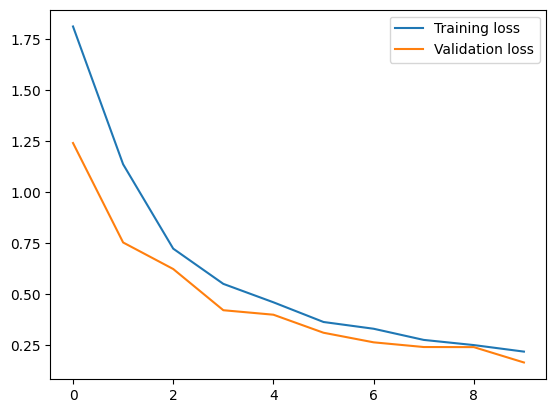

In [124]:
plt.plot(history.history['loss'][20:30], label='Training loss')
plt.plot(history.history['val_loss'][20:30], label='Validation loss')
plt.legend()